In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import keras
from keras.datasets import mnist, cifar10, fashion_mnist
import keras_utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
keras_utils.set_keras_session()

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
def cv2_rotate(image, degrees):
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(image, M, (cols,rows))

In [6]:
def pad(image, padding=4):
    
    h, w = image.shape
    image_padded = np.zeros((h + 2*padding, w + 2*padding))
    image_padded[padding:-padding, padding:-padding] = image
    return image_padded

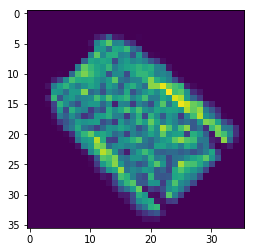

In [7]:
plt.imshow(cv2_rotate(pad(X_train[3501]), 45))

In [8]:
augmented_rotations_per_sample = 3
sector_perc = 1.0

In [9]:
def generate_random_rotations(X, Y, n_rotations_per_sample, even_odd):
    
    new_X = []
    new_Y = []
    rotations = []
    
    h, w = X.shape[1:]
    
    for image, label in tqdm(zip(X, Y), total=len(X), desc=str(sector_size)):
        
        image = pad(image)
        
        for _ in range(n_rotations_per_sample):
            
            while True:
                rand_sector = np.random.randint(sector_num)
                if rand_sector % 2 == even_odd:
                    central_angle = rand_sector * sector_size
                    break
            
            rotation = central_angle + np.random.uniform(-sector_perc, sector_perc) * sector_size / 2.
            
            rotated_image = cv2_rotate(image, rotation)
            new_X.append(rotated_image)
            new_Y.append(label)
            rotations.append(rotation)
    
    new_X = np.array(new_X)
    if len(new_X.shape) == 3:
        new_X = np.expand_dims(new_X, 3)
        
    return new_X, np.array(new_Y), np.array(rotations)

In [10]:
def create_rot_sin_cos(R_radians):
    rot_sin_cos = np.empty((len(R_radians), 2))
    rot_sin_cos[:, 0] = np.sin(R_radians)
    rot_sin_cos[:, 1] = np.cos(R_radians)
    return rot_sin_cos

In [11]:
from keras import layers
from keras import models
from keras import losses
import keras.backend as K

def cosine_proximity_unitary(y_true, y_pred):
    
    dot_product_loss = losses.cosine_proximity(y_true, y_pred)
    unit_circle_loss = K.square(1 - (K.square(y_pred[:, 0]) + K.square(y_pred[:, 1])))
    return dot_product_loss + 0.05 * unit_circle_loss


def build_model(use_labels=True, use_rotation=True, rot_range=-1):

    input_layer = layers.Input(X_train_rot.shape[1:], name='image_input')
    x = input_layer

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    flatten = layers.Flatten()(x)
    
    if use_labels:
        y = layers.Dense(128, activation='relu')(flatten)
        y = layers.Dropout(0.25)(y)
        y = layers.Dense(nb_classes, activation='softmax', name='y')(y)

    if use_rotation:
        r = layers.Dense(32, activation='relu')(flatten)
        r = layers.Dropout(0.5)(r)
        r = layers.Dense(2, name='r')(r)

    if use_labels and use_rotation:
        model = models.Model(input_layer, [y, r])        
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'cosine_proximity'], 
                      metrics={'y': 'accuracy', 'r': 'accuracy'},
                      loss_weights=[alpha, beta])
    elif use_labels:
        model = models.Model(input_layer, y)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    elif use_rotation:
        model = models.Model(input_layer, r)
        model.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])
    else:
        raise ValueError('Specify at least 1 output for the network!')
        
    #model.summary()
    
    return model

In [12]:
from keras import callbacks

class LossWeightsCallback(callbacks.Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            self.alpha = self.alpha - 0.4 # set to 0.5
            self.beta = self.beta + 0.4 # set to 0.5

In [13]:
def train_model(model, use_labels=True, use_rotation=True):
    
    if use_labels and use_rotation:
        y_train = [Y_train_onehot, R_train_sin_cos]
        y_test = [Y_test_onehot, R_test_sin_cos]
    elif use_labels:
        y_train = Y_train_onehot
        y_test = Y_test_onehot
    elif use_rotation:
        y_train = R_train
        y_test = R_test
    else:
        raise ValueError('Specify output for training')
        
    
    early_stopper = callbacks.EarlyStopping(patience=1)
    
    if use_labels and use_rotation:
        lw_callback = LossWeightsCallback(alpha, beta)
        _callbacks = [early_stopper, lw_callback]
    else:
        _callbacks = [early_stopper]
    
    return model.fit(X_train_rot, y_train, 
                     validation_data=(X_test_rot, y_test), 
                     callbacks=_callbacks,
                     batch_size=256,
                     epochs=10)

In [14]:
def min_diff(angle):
    if angle < 180:
        return angle
    elif angle < 360:
        return 360 - angle
    else:
        return angle - 360

In [15]:
histories = []
diff_degrees = []
diff_degrees_train = []


for sector_size in [1, 3, 5, 10, 15, 20, 30, 60]:

    sector_num = 360 // sector_size

    use_labels = True
    use_rotation = True

    X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, 
                                                                  augmented_rotations_per_sample, 0)
    X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, 
                                                               augmented_rotations_per_sample, 1)

    R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))
    R_train_sin_cos = create_rot_sin_cos(R_train_radians)
    R_test_sin_cos = create_rot_sin_cos(R_test_radians)

    Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
    Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

    nb_classes = Y_train_onehot.shape[1]

    alpha = K.variable(0.9)
    beta = K.variable(0.1)
    model = build_model(use_labels, use_rotation)

    history = train_model(model, use_labels, use_rotation).history
    histories.append(history)

    _, R_pred = model.predict(X_test_rot)
    
    diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
    diff_degree = np.array([min_diff(diff) for diff in diff_degree])
    print(np.mean(diff_degree))
    diff_degrees.append(diff_degree)
    
    
    X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_train, Y_train, 1, 1)
    _, R_pred = model.predict(X_test_rot)
    diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
    diff_degree = np.array([min_diff(diff) for diff in diff_degree])
    print(np.mean(diff_degree))
    diff_degrees_train.append(diff_degree)
    

1: 100%|██████████| 10000/10000 [00:00<00:00, 10677.22it/s]


Instructions for updating:
dim is deprecated, use axis instead
Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 35s 192us/step - loss: 6.9040 - y_loss: 7.7302 - r_loss: -0.5312 - y_acc: 0.3534 - r_acc: 0.7209 - val_loss: 0.5681 - val_y_loss: 0.7257 - val_r_loss: -0.8497 - val_y_acc: 0.7437 - val_r_acc: 0.8672
Epoch 2/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.5627 - y_loss: 0.7105 - r_loss: -0.7675 - y_acc: 0.7457 - r_acc: 0.8292 - val_loss: 0.4267 - val_y_loss: 0.5737 - val_r_loss: -0.8965 - val_y_acc: 0.7959 - val_r_acc: 0.9025
Epoch 3/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.4451 - y_loss: 0.5840 - r_loss: -0.8047 - y_acc: 0.7892 - r_acc: 0.8511 - val_loss: 0.3757 - val_y_loss: 0.5187 - val_r_loss: -0.9113 - val_y_acc: 0.8134 - val_r_acc: 0.9119
Epoch 4/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.3840 - y_loss: 0.5185 - 

1:   5%|▍         | 2886/60000 [00:00<00:01, 28855.97it/s]

10.656173302826467


3:   2%|▏         | 1069/60000 [00:00<00:05, 10685.78it/s]

10.52964669331698


3: 100%|██████████| 10000/10000 [00:00<00:00, 10553.43it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 34s 187us/step - loss: 1.0958 - y_loss: 1.2940 - r_loss: -0.6878 - y_acc: 0.6655 - r_acc: 0.7911 - val_loss: 0.4544 - val_y_loss: 0.6037 - val_r_loss: -0.8891 - val_y_acc: 0.7838 - val_r_acc: 0.8967
Epoch 2/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.4700 - y_loss: 0.6114 - r_loss: -0.8029 - y_acc: 0.7809 - r_acc: 0.8544 - val_loss: 0.3883 - val_y_loss: 0.5327 - val_r_loss: -0.9113 - val_y_acc: 0.8053 - val_r_acc: 0.9205
Epoch 3/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.3969 - y_loss: 0.5335 - r_loss: -0.8331 - y_acc: 0.8055 - r_acc: 0.8702 - val_loss: 0.3554 - val_y_loss: 0.4971 - val_r_loss: -0.9197 - val_y_acc: 0.8196 - val_r_acc: 0.9225
Epoch 4/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.3523 - y_loss: 0.4858 - r_loss: -0.8491 - y_acc: 0.8217 - r_acc: 0.8785 - val_loss: 0.3

3:   9%|▉         | 5692/60000 [00:00<00:01, 28454.63it/s]

10.038269926321552


5:   2%|▏         | 1052/60000 [00:00<00:05, 10515.55it/s]

10.082412309401443


5: 100%|██████████| 10000/10000 [00:00<00:00, 10672.20it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 34s 188us/step - loss: 1.0570 - y_loss: 1.2506 - r_loss: -0.6856 - y_acc: 0.6712 - r_acc: 0.7883 - val_loss: 0.4379 - val_y_loss: 0.5839 - val_r_loss: -0.8757 - val_y_acc: 0.7937 - val_r_acc: 0.8972
Epoch 2/10
180000/180000 [==============================] - 33s 186us/step - loss: 0.4607 - y_loss: 0.6001 - r_loss: -0.7943 - y_acc: 0.7837 - r_acc: 0.8441 - val_loss: 0.3809 - val_y_loss: 0.5234 - val_r_loss: -0.9018 - val_y_acc: 0.8096 - val_r_acc: 0.9108
Epoch 3/10
180000/180000 [==============================] - 34s 186us/step - loss: 0.3885 - y_loss: 0.5230 - r_loss: -0.8221 - y_acc: 0.8103 - r_acc: 0.8628 - val_loss: 0.3437 - val_y_loss: 0.4839 - val_r_loss: -0.9181 - val_y_acc: 0.8244 - val_r_acc: 0.9211
Epoch 4/10
180000/180000 [==============================] - 33s 186us/step - loss: 0.3464 - y_loss: 0.4777 - r_loss: -0.8354 - y_acc: 0.8246 - r_acc: 0.8724 - val_loss: 0.3

5:   5%|▍         | 2759/60000 [00:00<00:02, 27579.64it/s]

10.547894450007952


10:   2%|▏         | 1099/60000 [00:00<00:05, 10985.11it/s]

10.474475410823182


10: 100%|██████████| 10000/10000 [00:00<00:00, 10227.09it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 34s 188us/step - loss: 1.4456 - y_loss: 1.6795 - r_loss: -0.6596 - y_acc: 0.6495 - r_acc: 0.7799 - val_loss: 0.5458 - val_y_loss: 0.7009 - val_r_loss: -0.8499 - val_y_acc: 0.7481 - val_r_acc: 0.8818
Epoch 2/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.4701 - y_loss: 0.6097 - r_loss: -0.7861 - y_acc: 0.7796 - r_acc: 0.8428 - val_loss: 0.4731 - val_y_loss: 0.6237 - val_r_loss: -0.8826 - val_y_acc: 0.7773 - val_r_acc: 0.9067
Epoch 3/10
180000/180000 [==============================] - 34s 186us/step - loss: 0.3931 - y_loss: 0.5275 - r_loss: -0.8161 - y_acc: 0.8079 - r_acc: 0.8590 - val_loss: 0.4406 - val_y_loss: 0.5889 - val_r_loss: -0.8941 - val_y_acc: 0.7877 - val_r_acc: 0.9077
Epoch 4/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.3478 - y_loss: 0.4794 - r_loss: -0.8361 - y_acc: 0.8240 - r_acc: 0.8700 - val_loss: 0.4

10:   4%|▍         | 2659/60000 [00:00<00:02, 26576.91it/s]

15.369142905332248


15:   2%|▏         | 1050/60000 [00:00<00:05, 10488.63it/s]

15.470226476519047


15: 100%|██████████| 10000/10000 [00:00<00:00, 10394.22it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 34s 188us/step - loss: 0.8061 - y_loss: 0.9759 - r_loss: -0.7218 - y_acc: 0.7035 - r_acc: 0.8146 - val_loss: 0.5607 - val_y_loss: 0.7126 - val_r_loss: -0.8064 - val_y_acc: 0.7476 - val_r_acc: 0.8578
Epoch 2/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.4188 - y_loss: 0.5574 - r_loss: -0.8277 - y_acc: 0.7999 - r_acc: 0.8797 - val_loss: 0.5020 - val_y_loss: 0.6515 - val_r_loss: -0.8441 - val_y_acc: 0.7618 - val_r_acc: 0.8801
Epoch 3/10
180000/180000 [==============================] - 34s 186us/step - loss: 0.3539 - y_loss: 0.4878 - r_loss: -0.8508 - y_acc: 0.8236 - r_acc: 0.8911 - val_loss: 0.4762 - val_y_loss: 0.6240 - val_r_loss: -0.8540 - val_y_acc: 0.7693 - val_r_acc: 0.8846
Epoch 4/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.3139 - y_loss: 0.4444 - r_loss: -0.8607 - y_acc: 0.8373 - r_acc: 0.8980 - val_loss: 0.4

15:   5%|▍         | 2803/60000 [00:00<00:02, 28024.35it/s]

17.106345592319645


20:   2%|▏         | 1084/60000 [00:00<00:05, 10833.84it/s]

17.05779321163758


20: 100%|██████████| 10000/10000 [00:00<00:00, 10748.07it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 34s 189us/step - loss: 1.2852 - y_loss: 1.5100 - r_loss: -0.7384 - y_acc: 0.6764 - r_acc: 0.8177 - val_loss: 0.8903 - val_y_loss: 1.0581 - val_r_loss: -0.6195 - val_y_acc: 0.6189 - val_r_acc: 0.7617
Epoch 2/10
180000/180000 [==============================] - 33s 185us/step - loss: 0.4204 - y_loss: 0.5613 - r_loss: -0.8478 - y_acc: 0.7979 - r_acc: 0.8832 - val_loss: 0.8526 - val_y_loss: 1.0192 - val_r_loss: -0.6467 - val_y_acc: 0.6438 - val_r_acc: 0.7835
Epoch 3/10
180000/180000 [==============================] - 34s 186us/step - loss: 0.3516 - y_loss: 0.4876 - r_loss: -0.8724 - y_acc: 0.8208 - r_acc: 0.8937 - val_loss: 0.8722 - val_y_loss: 1.0409 - val_r_loss: -0.6463 - val_y_acc: 0.6398 - val_r_acc: 0.7979


20:   5%|▍         | 2822/60000 [00:00<00:02, 28216.26it/s]

38.57847607438119


30:   2%|▏         | 1092/60000 [00:00<00:05, 10914.23it/s]

38.14604593565807


30: 100%|██████████| 10000/10000 [00:00<00:00, 10813.42it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 34s 190us/step - loss: 1.2142 - y_loss: 1.4304 - r_loss: -0.7321 - y_acc: 0.7062 - r_acc: 0.8217 - val_loss: 2.2108 - val_y_loss: 2.5064 - val_r_loss: -0.4496 - val_y_acc: 0.4106 - val_r_acc: 0.6542
Epoch 2/10
180000/180000 [==============================] - 33s 186us/step - loss: 0.3772 - y_loss: 0.5133 - r_loss: -0.8484 - y_acc: 0.8140 - r_acc: 0.9035 - val_loss: 2.3975 - val_y_loss: 2.7149 - val_r_loss: -0.4587 - val_y_acc: 0.4191 - val_r_acc: 0.6694


30:   5%|▍         | 2783/60000 [00:00<00:02, 27823.92it/s]

55.68667242748086


60:   2%|▏         | 1100/60000 [00:00<00:05, 10991.21it/s]

55.6424873639008


60: 100%|██████████| 10000/10000 [00:00<00:00, 10625.07it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 34s 190us/step - loss: 0.9073 - y_loss: 1.1036 - r_loss: -0.8594 - y_acc: 0.7301 - r_acc: 0.8863 - val_loss: 2.1630 - val_y_loss: 2.3827 - val_r_loss: 0.1858 - val_y_acc: 0.3503 - val_r_acc: 0.4361
Epoch 2/10
180000/180000 [==============================] - 33s 186us/step - loss: 0.3520 - y_loss: 0.4934 - r_loss: -0.9210 - y_acc: 0.8208 - r_acc: 0.9116 - val_loss: 2.4537 - val_y_loss: 2.7109 - val_r_loss: 0.1392 - val_y_acc: 0.3469 - val_r_acc: 0.4439


60:   9%|▉         | 5562/60000 [00:00<00:01, 27805.55it/s]

101.48455026146881


60: 100%|██████████| 60000/60000 [00:02<00:00, 28094.89it/s]


100.94447544272367


In [16]:
np.mean(diff_degrees, axis=1)

array([ 10.6561733 ,  10.03826993,  10.54789445,  15.36914291,
        17.10634559,  38.57847607,  55.68667243, 101.48455026])

In [17]:
Y_pred, R_pred = model.predict(X_test_rot)

In [37]:
def get_data_from_histories():

    for history in histories:

        idx_min_loss = np.argmin(history['val_loss'])
        data = []

        for key in ('val_loss', 'val_r_loss', 'val_y_loss', 'val_y_acc'):
            data.append(history[key][idx_min_loss])
            
        yield data

In [38]:
data = np.array(list(get_data_from_histories()))

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

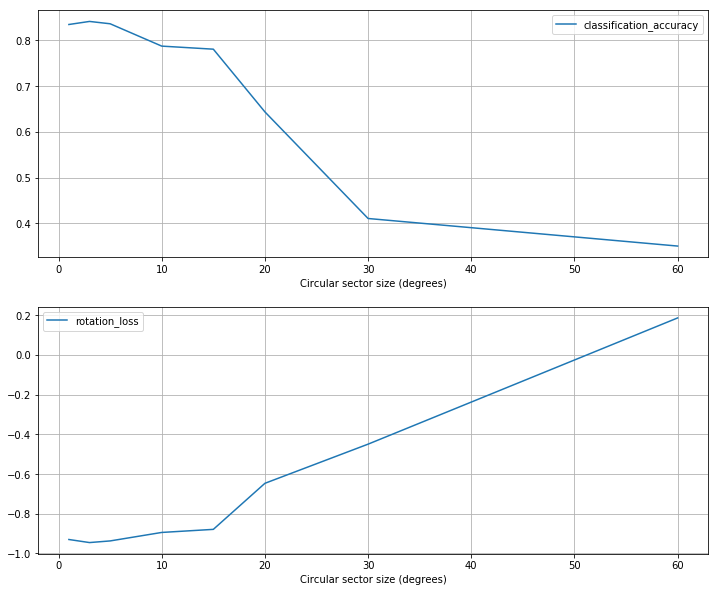

In [40]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.grid()
plt.plot([1, 3, 5, 10, 15, 20, 30, 60], data[:, 3], label='classification_accuracy')
plt.xlabel('Circular sector size (degrees)')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot([1, 3, 5, 10, 15, 20, 30, 60], data[:, 1], label='rotation_loss')
plt.xlabel('Circular sector size (degrees)')
plt.legend()

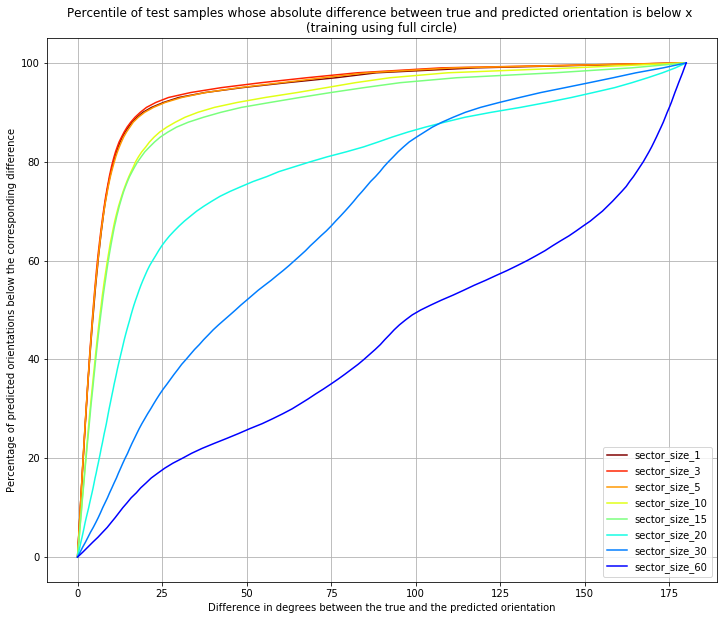

In [23]:
xv = np.arange(0, 101)
plt.figure(figsize=(12, 10))
plt.grid()

cmap = plt.get_cmap('jet_r')
for i, (diff_degree, sector_size) in enumerate(zip(diff_degrees, [1, 3, 5, 10, 15, 20, 30, 60])):
    color = cmap(float(i)/len(diff_degrees))
    plt.plot([np.percentile(diff_degree, x) for x in xv], xv, c=color, 
             label='sector_size_{}'.format(sector_size))
    
plt.title('Percentile of test samples whose absolute difference between true and predicted orientation is below x \n(training using full circle)')
plt.xlabel('Difference in degrees between the true and the predicted orientation')
plt.ylabel('Percentage of predicted orientations below the corresponding difference')
plt.legend()
plt.show()